# Вариант 1

**Цель:** Контроль дисперсии весов.

- Разработайте архитектуру, которая будет за **5 слоев** приводить тензор к размерности `(1, 512, 1, 1)`.
- **Условие:** дисперсия весов третьего слоя должна быть в **два раза больше**, чем у второго и четвертого.
- **Эксперимент:** Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [36]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.convLayer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.convLayer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.convLayer4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.convLayer5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.activation = nn.ReLU()
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.convLayer1(x)
        x = self.activation(x)
        
        x = self.convLayer2(x)
        x = self.activation(x)
        
        x = self.convLayer3(x)
        x = self.activation(x)
        
        x = self.convLayer4(x)
        x = self.activation(x)
        
        x = self.convLayer5(x)
        x = self.activation(x)
        
        x = self.avgPool(x)
        return x

In [ ]:
class MyNetScaled(nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.convLayer2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.convLayer3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.convLayer4 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.convLayer5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.convLayer1(x)
        x = self.activation(x)
        
        x = self.convLayer2(x)
        x = self.activation(x)
        
        x = self.convLayer3(x)
        x = self.activation(x)
        
        x = self.convLayer4(x)
        x = self.activation(x)
        
        x = self.convLayer5(x)
        x = self.activation(x)
        
        x = self.avgPool(x)
        return x

Обе созданные сети на вход принимают тензор размера `(1, 3, 16, 16)` и преобразуют в размер `(1, 512, 1, 1)`.

In [39]:
models = [MyNet(), MyNetScaled()]
model_names = ['general', 'scaled']

# batch=1, channel=3, size=16x16
test_tensor = torch.randn(1, 3, 16, 16)

for mdl in models:
    # batch=1, channel=3, size=16x16
    print(mdl(test_tensor).shape)

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])


Проверка соотношений между дисперсиями 2, 3 и 4 слоев.

In [40]:
for mdl_name, mdl in zip(model_names, models):
    print(mdl_name + ':')
    var2 = mdl.convLayer2.weight.data.var().item()
    var3 = mdl.convLayer3.weight.data.var().item()
    var4 = mdl.convLayer4.weight.data.var().item()
    print('var3/var2:', np.round(var3/var2,2))
    print('var3/var4:', np.round(var3/var4,2))

general:
var3/var2: 0.5
var3/var4: 1.99
scaled:
var3/var2: 2.06
var3/var4: 2.01


Преобразуем результаты в numpy-массивы.

In [41]:
outputs = []
with torch.no_grad():
    for m, mdl in enumerate(models):
        outputs.append(mdl(test_tensor).squeeze().cpu().numpy())
        print(outputs[m].shape)

(512,)
(512,)


Строим гистограммы.

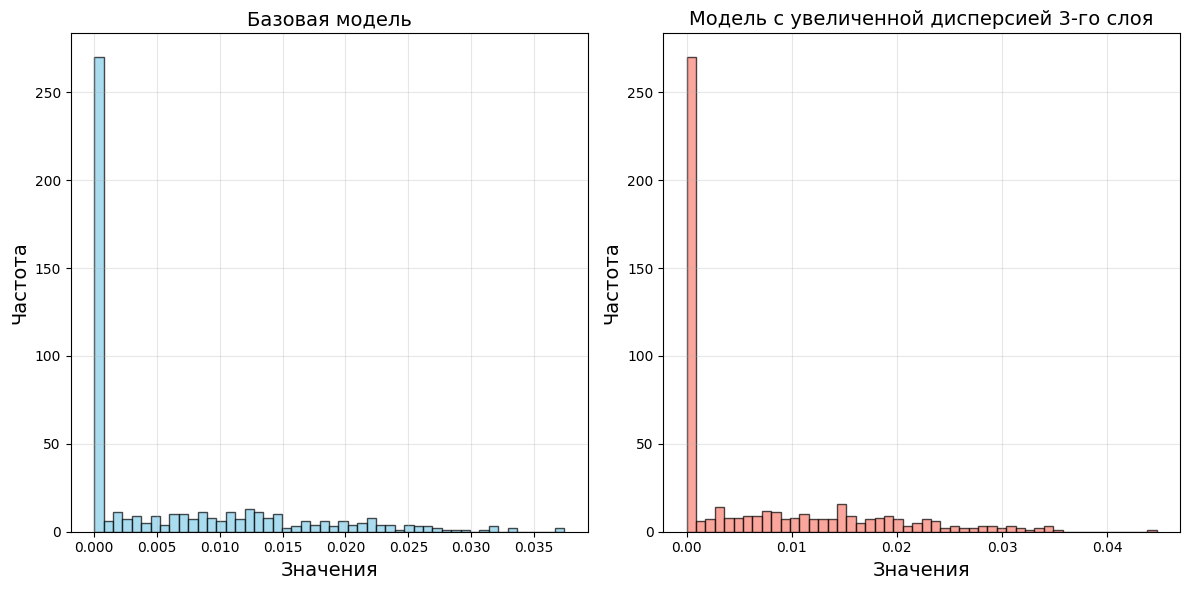

In [45]:
user_colors = ['skyblue', 'salmon']
user_labels = ['Базовая модель', 'Модель с увеличенной дисперсией 3-го слоя']

plt.figure(figsize=(12, 6))
for m, out in enumerate(outputs):
    plt.subplot(1, 2, m+1)
    plt.hist(out, bins=50, alpha=0.7, color=user_colors[m], edgecolor='black')
    plt.title(user_labels[m], fontsize=14)
    plt.xlabel('Значения', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()